# Blind Image Deconvolution (BID) Demonstration

This notebook gives a demonstration of one type of Blind Image Deconvolution using the modified Davey Algorithm.

We begin with some housekeeping (Python imports)

In [1]:
import imageio                                                # Image file I/O
import numpy as np                                            # Matrix support, FFT etc
import math as m
from scipy import signal                                      # Signal processing library
from IPython.display import Math                              # LaTex support
import matplotlib.pyplot as plot                              # Plots

#from modifiedDaveyDeblur_ori import bid_davey, InitialEstimate    # Blind image deconvolution

import cv2

Next, import our image of choice...

Source image dimensions: (273, 307, 3)


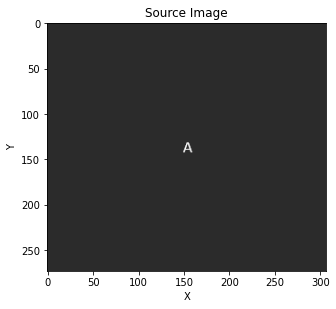

In [2]:
image_name = 'src_images/star.bmp'

#image_name="C:\\Users\\SYunMoon\\Desktop\\lucky_region.png"
image_name='C:\\Users\\SYunMoon\\Desktop\\Capture.PNG'
# Load and show source image
#src_img = imageio.imread(image_name)
img = cv2.imread(image_name,0)
i = img[:,:].copy()

#image = cv2.imread("D:/image/turbulence_midigation/153401.bmp",0)
#img = cv2.resize(image,(640,512),interpolation = cv2.INTER_AREA)
src_img = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB)

print ("Source image dimensions:", src_img.shape)

plot.figure(figsize=(5,5))
plot.title('Source Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(src_img)

Next, we add some 'atmospheric blurring'. This is achieved by running the source image through a circular (pillbox) filter. The larger the blur kernel, the smoother the image becomes.

<img src="img/blurring.png" width="600">

If:
* f(x,y) is our source image before blurring
* h(x,y) is the effective transfer function modelling the blurring mechanism (Point Spread Function)
* g(x,y) is our blurred image


then the blurred image is the result of the 2D-convolution of each RGB colour channel with the PSF:

In [28]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y)')

<IPython.core.display.Math object>

Blurred image dimensions: (293, 327, 3)


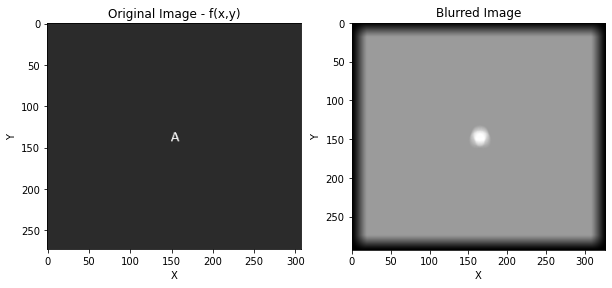

In [3]:
# Create circular filter PSF
#X,Y=np.meshgrid(np.linspace(-10,10,10),np.linspace(-10,10,10))
"""
r = 10
Y,X = np.ogrid[-r: r+1, -r: r+1]
a, mu,sigma = 1 , 0, 10
psf=a * np.exp(-((X-mu)**2+(Y-mu)**2)/(2.0*sigma**2))

"""
r = 10
y,x = np.ogrid[-r: r+1, -r: r+1]
psf = x**2+y**2 <= r**2
psf = psf.astype(float) / np.sum(psf)


blur_img = np.zeros((src_img.shape[0] + 2*r, src_img.shape[1] + 2*r, src_img.shape[2]))
print ("Blurred image dimensions:", blur_img.shape)

for ch in range(src_img.shape[2]):    
    blur_img[:,:,ch] = signal.convolve2d(src_img[:,:,ch], psf, mode ='full', boundary = 'fill', fillvalue = 0)

    
# Plot before and after blurring    
plot.figure(figsize=(10,10))
plot.subplot(1, 2, 1)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(src_img)

plot.subplot(1, 2, 2)
plot.title('Blurred Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(blur_img/np.max(blur_img))


Realisitically some noise is added to the system during the capture process. This manifests from things like:
-  electronic noise
-  thermal noise at the CCD camera
-  quantisation noise

We model this by using an additive unknown noise term n(x,y), with the properites of being a zero-mean Gaussian random variable.

![image.png](img/1d_gaussian.jpg)

so we now have:

In [30]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y) + n(x,y)')

<IPython.core.display.Math object>

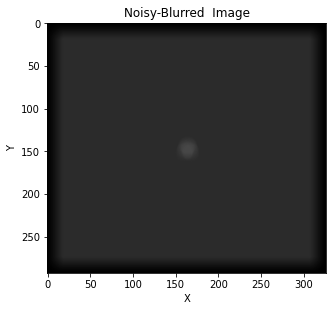

In [4]:
# Add Gaussian noise to the observed image
mu, sigma = 0, 0.1
scale = 0.0
noise = scale * np.multiply(np.random.normal(mu, sigma, blur_img.shape), blur_img)

noisyBlur_img = np.add(blur_img, noise)
noisyBlur_img = np.round(noisyBlur_img, 0).astype(np.uint8)
imageio.imsave( '_blurred.'.join(image_name.rsplit('.', 1)), (np.divide(noisyBlur_img, np.max(noisyBlur_img))*255).astype(np.uint8))

# Plot noisy, blurred image
plot.figure(figsize=(5,5))
plot.title('Noisy-Blurred  Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(noisyBlur_img)

We can define the signal to noise ratio (SNR) as:

In [32]:
Math(r'SNR(dB) = 20\log_{10}  \Bigg(   \frac {A_{signal}} {A_{noise}} \Bigg)')

<IPython.core.display.Math object>

In [33]:
Math(r'SNR (dB) = P(dB)_{signal} - P (dB)_{noise}')

<IPython.core.display.Math object>

In [5]:
def power(image):
    return 20*np.log10( np.sqrt(np.mean(np.square(image))) )

signalPower = power(blur_img)
noisePower  = power(noise)
snr         = signalPower - noisePower
print("SNR = {0} dB".format(snr))


SNR = inf dB


C:\Users\SYunMoon\AppData\Local\Temp/ipykernel_26280/4015021899.py:2: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10( np.sqrt(np.mean(np.square(image))) )


lower: 126, upper: 147
left: 143, right: 164
noisyBlur_img: (293, 327, 3)
psf: (21, 21)
psfplot: (273, 307)


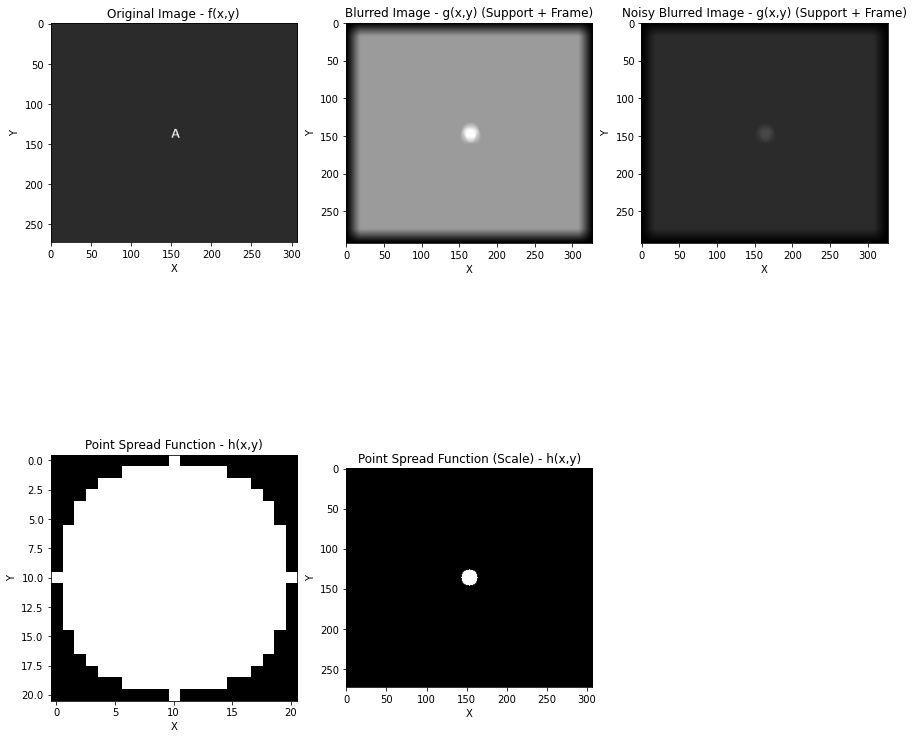

In [6]:
 
# Plot before and after blurring    
plot.figure(figsize=(15,15))
plot.subplot(2, 3, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 2)
plot.imshow(blur_img/np.max(blur_img))
plot.title('Blurred Image - g(x,y) (Support + Frame)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 3)
plot.imshow(noisyBlur_img)
plot.title('Noisy Blurred Image - g(x,y) (Support + Frame)')
plot.xlabel('X')
plot.ylabel('Y')


# Show PSF
"""
psfplot = np.zeros((src_img.shape[0], src_img.shape[1]))
nb = psfplot.shape[0]
na = psf.shape[0]
lower = (nb) // 2 - (na // 2)
upper = (nb) // 2 + math.ceil(float(na) / 2)
psfplot[lower:int(upper), lower:int(upper)] = psf
"""
# Show PSF
psfplot = np.zeros((src_img.shape[0], src_img.shape[1]))
nb = psfplot.shape[0]
na = psf.shape[0]
lower = (nb) // 2 - (na // 2)
upper = (nb) // 2 + m.ceil(float(na) / 2)
print ("lower: {}, upper: {}".format(lower, upper))

widthnb = psfplot.shape[1]
widthna = psf.shape[1]
left = (widthnb) // 2 - (widthna // 2)
right = (widthnb) // 2 + m.ceil(float(widthna) / 2)
print ("left: {}, right: {}".format(left, right))

psfplot[lower:int(upper), left:int(right)] = psf


plot.subplot(2, 3, 4)
plot.imshow(psf, cmap='gray')
plot.title('Point Spread Function - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 5)
plot.imshow(psfplot, cmap='gray')
plot.title('Point Spread Function (Scale) - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')
print ("noisyBlur_img: {}".format(noisyBlur_img.shape))
print ("psf: {}".format(psf.shape))
print ("psfplot: {}".format(psfplot.shape))


noisyBlur_img: (293, 327, 3)
(273, 307, 3)
(293, 327, 3)


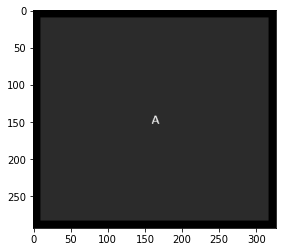

In [11]:
print ("noisyBlur_img: {}".format(noisyBlur_img.shape))
print (src_img.shape)
luckyR=np.zeros((273+20,307+20))
luckyR[10:283,10:317] = src_img[:,:,0]
plot.imshow(luckyR,'gray')
luckyR = cv2.cvtColor(luckyR.astype(np.uint8),cv2.COLOR_GRAY2RGB)
print (luckyR.shape)

In [12]:
print (lower,upper, left,right)

126 147 143 164


In [13]:
psfplot.shape

(273, 307)

Next we apply the Davey Blind image deconvolution algorithm to iteratively 'deblur' the noisy image...

<img src="img/davey_algorithm_flow.png" width="600">



In [14]:
#640x512 image

import os 
in_dir = 'D:/image/turbulence_midigation'
input = []

for count,i in enumerate(os.listdir(in_dir)):

    new_image = cv2.imread(os.path.join(in_dir,i),0)
    new_image = cv2.resize(new_image,(640,512),interpolation = cv2.INTER_AREA)
    input.append(new_image)
    if count == 30 : break

image_mean = np.mean(input,axis=0)

input_image = np.zeros((noisyBlur_img.shape[0],noisyBlur_img.shape[1]))

lower_large = (noisyBlur_img.shape[0]) // 2 - (image_mean.shape[0] // 2)
upper_large  = (noisyBlur_img.shape[0]) // 2 + (image_mean.shape[0] // 2)

left_large  = (noisyBlur_img.shape[1]) // 2 - (image_mean.shape[1] // 2)
right_large  = (noisyBlur_img.shape[1]) // 2 + (image_mean.shape[1] // 2)


print (lower_large , upper_large , left_large ,right_large )
input_image[lower_large :upper_large , left_large :right_large] = image_mean
input_image[lower_large :upper_large , left_large :right_large] = src_img
plot.imshow(input_image,'gray')

input_image = cv2.cvtColor(input_image.astype(np.uint8),cv2.COLOR_GRAY2RGB)
print (input_image.shape)

-110 402 -157 483


ValueError: could not broadcast input array from shape (512,640) into shape (110,157)

In [15]:
def bid_davey(original_img, original_psf, blurred_img, psfWidth, psfHeight, iterations):
    result_list=[]
    """
    snapshot_filenames = []
    if (save_snapshots) :
        if os.path.exists(SNAPSHOT_DIR):
            shutil.rmtree(SNAPSHOT_DIR)
        os.mkdir(SNAPSHOT_DIR)
    """

    result = 0                                    # Optimal restored image

    original_img = original_img.astype(float)
    blurred_img = blurred_img.astype(float)

    supportWidth = np.shape(original_img)[1]
    supportHeight = np.shape(original_img)[0]
    channels = np.shape(original_img)[2]

    entireWidth = np.shape(blurred_img)[1]
    entireHeight = np.shape(blurred_img)[0]



    # Embed original image within and psf frame
    frame = np.zeros((entireHeight, entireWidth, channels))
    origin_x = (np.ceil((entireWidth-supportWidth)/2)+1).astype(int)
    origin_y = (np.ceil((entireHeight-supportHeight)/2)+1).astype(int)
    frame[origin_y:(origin_y+supportHeight), origin_x:(origin_x+supportWidth), 0:channels] = original_img
    original_img = frame

    frame = np.zeros((entireHeight, entireWidth, channels))
    frame[origin_y:(origin_y+supportHeight), origin_x:(origin_x+supportWidth), :] = np.dstack((original_psf, original_psf, original_psf))
    original_psf = frame


    # Storage for tracking MSE vs iteration count
    image_mse = np.zeros((iterations, 2))                 # Initialise image MSE array
    psf_mse = np.zeros((iterations, 2))                   # Initialise PSF MSE array

    min_mse = 0                                           # Minimum f(^(x,y) MSE
    min_mse_iterations = 0                                # Number of iterations to achieve minimum f(^(x,y) MSE

    """
    ##########################
    # Set up initial conditions
    #
    # 4 options :-
    #
    #  1) Use observed (blurred) image as starting point
    #  2) Random initial estimate
    #  3) Non-zero constant as initial estimate
    #
    initial_estimate = None
    if initial == InitialEstimate.RANDOM:
        initial_estimate = np.round(255*np.random.rand(entireHeight, entireWidth, channels))

    elif initial == InitialEstimate.CONSTANT:
        initial_estimate = np.multiply(np.ones((entireHeight, entireWidth, channels)), 100)

    else:
    """
    initial_estimate = blurred_img


    f = initial_estimate

    g = blurred_img

    ##########################

    # Message display
    print ("Performing optimal deblur. Progress: [")

    # Used for progress bar display
    countMAX = np.round(iterations * 0.05) # 5% increments
    counter = 0

    h = None
    G = np.fft.fft2(g, axes=(0,1))

    for iteration in range (0, iterations):
        print ("counter: {}".format(counter))
        counter += 1
        
        if (counter == countMAX):
            print (".")                     # Progress bar display
            counter = 0
            if (save_snapshots):
                generateSnapshot(f, channels, iteration, SNAPSHOT_DIR, snapshot_filenames)

        F = np.fft.fft2(f, axes=(0,1))
        H = wiener(G, F)                                     # Wiener constraint
        h = np.fft.fftshift(np.fft.ifft2(H, axes=(0,1)), axes=(0,1))
        h = psfConstraint(h, (psfWidth, psfHeight), (supportWidth, supportHeight))
        H = np.fft.fft2(h, axes=(0,1))
        F = wiener(G, H)                                     # Wiener constraint
        f = np.fft.fftshift(np.fft.ifft2(F, axes=(0,1)), axes=(0,1))
        f = imageConstraint(f, (supportWidth, supportHeight))

        if (iteration == iterations - 1):
            print ("] (complete)")

        # Calculate and store Mean Squared Error for iteration
        f_mse = computeMSE(f, original_img)
        h_mse = computeMSE(h, original_psf)
        image_mse[iteration, 0] = psf_mse[iteration, 0] = iteration
        image_mse[iteration, 1] = f_mse
        psf_mse[iteration, 1] = h_mse

        if (iteration == 0):
            min_mse = f_mse
            min_mse_iterations = 0
            result = f

        if (f_mse < min_mse):
            min_mse = f_mse
            min_mse_iterations = iteration
            result = f
            result = result[origin_y:origin_y+supportHeight, origin_x:origin_x+supportWidth, 0:channels]
        for ch in range (0, channels):
            result[:, :, ch] = np.multiply(np.divide(result[:, :, ch], np.max(result[:, :, ch])), 255)
        result = np.abs(result).astype(np.uint8)
        result_list.append(result)
    # end for loop


    # Prepare to return results
    result = result[origin_y:origin_y+supportHeight, origin_x:origin_x+supportWidth, 0:channels]
    for ch in range (0, channels):
        result[:, :, ch] = np.multiply(np.divide(result[:, :, ch], np.max(result[:, :, ch])), 255)
    result = np.abs(result).astype(np.uint8)

    restored_psf = h[:,:,1]
    restored_psf = np.multiply(np.divide(restored_psf, np.max(restored_psf)), 255)
    restored_psf = np.abs(restored_psf).astype(np.uint8)

    """
    if(save_snapshots):
        images = []
        for filename in snapshot_filenames:
            images.append(imageio.imread(filename))
            imageio.mimsave(SNAPSHOT_DIR + '/snapshots.gif', images, format='GIF', duration=1)
    """
    return (result_list, result, restored_psf, image_mse, psf_mse, min_mse, min_mse_iterations)


def psfConstraint(data, psf_dims, support):

    supportWidth = support[0]
    supportHeight = support[1]
    entireWidth = data.shape[1]
    entireHeight = data.shape[0]
    channels = data.shape[2]

    psfHeight  = psf_dims[1]
    psfWidth = psf_dims[0]

    origin_x = int(m.ceil((float(entireWidth - psfWidth) / 2) + 1))
    origin_y = int(m.ceil((float(entireHeight - psfHeight) / 2) + 1))

    # Enforce positivity and support constraints
    frame = np.zeros((entireHeight, entireWidth, channels))
    frame[origin_y-1 : origin_y+psfHeight-1, origin_x-1 : origin_x+psfWidth-1, 0:channels] = np.ones((psfHeight, psfWidth, channels))
    data = np.multiply(data, frame).clip(min=0)

    # TODO check whether whole thing should be set to zero if <0 -- or just individual real/complex parts

    return data


def imageConstraint(data, support):

    entireWidth = data.shape[1]
    entireHeight = data.shape[0]
    channels = data.shape[2]

    supportWidth = support[0]
    supportHeight = support[1]

    origin_x = int(m.ceil((float(entireWidth - supportWidth) / 2) + 1))
    origin_y = int(m.ceil((float(entireHeight - supportHeight) / 2) + 1))

    # Enforce positivity and support constraints
    frame = np.zeros((entireHeight, entireWidth, channels))
    frame[origin_y-1 : origin_y+supportHeight-1, origin_x-1 : origin_x+supportWidth-1, 0:channels] = np.ones((supportHeight, supportWidth, channels))
    data = np.multiply(data, frame).clip(min=0)

    return data



def wiener (num, den):
    beta = 0.5
    W = np.divide(np.conj(den), np.square(np.abs(den)) + np.divide(beta, np.square(np.abs(den)) ) )
    return np.multiply(W, num)


# Calculate the Mean Squared Error (MSE) between two matrices
def computeMSE(estimate, original):
    mse = 0

    # Normalise estimate
    estimate = np.multiply(np.divide(estimate, np.max(estimate)), 255)
    if (estimate.shape != original.shape):
        raise Exception('ERROR: estimate %s and original %s are not the same dimensions [computeMSE()].' % (estimate.shape, original.shape))
    else:
        mse = np.abs(np.square(np.subtract(estimate, original)).mean())

    return mse

src_img: (273, 307, 3), psfplot: (273, 307), noisyBlur_img: (293, 327, 3),psf: (21, 21)
Performing optimal deblur. Progress: [
counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
counter: 20
counter: 21
counter: 22
counter: 23
counter: 24
counter: 25
counter: 26
counter: 27
counter: 28
counter: 29
counter: 30
counter: 31
counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
.
counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
counter: 20
counter: 21
counter: 22
counter: 23
cou

counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
.
counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
counter: 20
counter: 21
counter: 22
counter: 23
counter: 24
counter: 25
counter: 26
counter: 27
counter: 28
counter: 29
counter: 30
counter: 31
counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
.
counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter:

Text(0, 0.5, 'MSE')

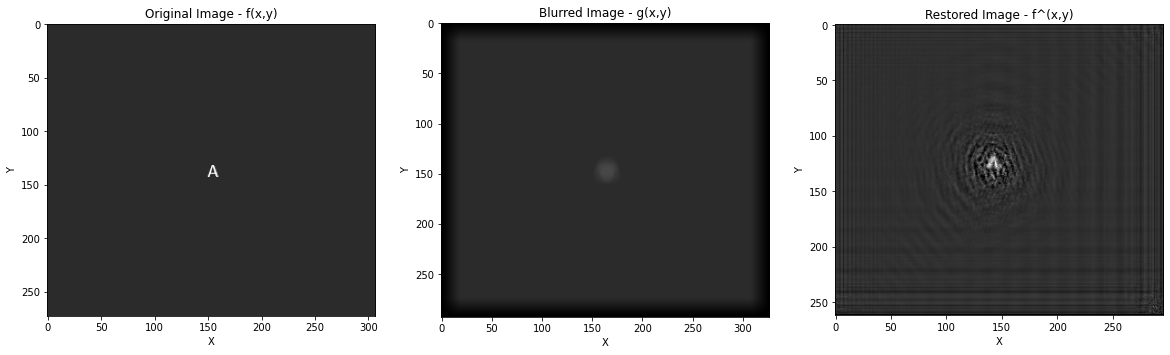

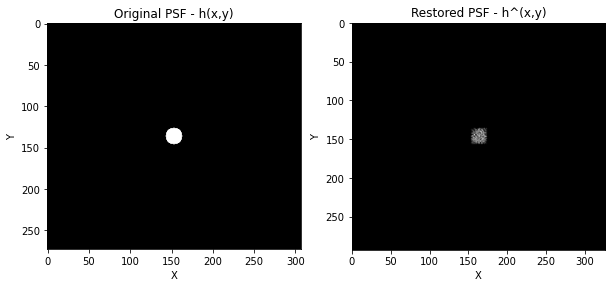

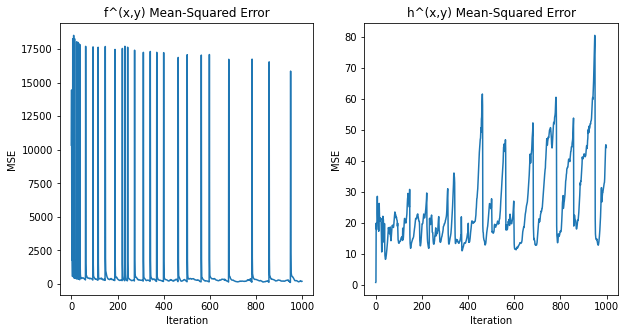

In [65]:
# BID iterations
iterations = 1000
save_snapshots = False  # True / False
result_list=[]
print ("src_img: {}, psfplot: {}, noisyBlur_img: {},psf: {}".format(src_img.shape,psfplot.shape,noisyBlur_img.shape,psf.shape) )
(result_list,restored_img, restored_psf, image_mse, psf_mse, mse_min, mse_min_iterations) = bid_davey(src_img, psfplot, noisyBlur_img, psf.shape[0],psf.shape[1], iterations)

imageio.imsave( '_restored.'.join(image_name.rsplit('.', 1))  , restored_img) # Save the result



print ("Results:")
print ("--------")
print ("Minimum MSE of %d occurs at iteration# %d." % (m.ceil(mse_min), mse_min_iterations))

# Plot recovered image
plot.figure(figsize=(20,20))
plot.subplot(1, 3, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 2)
plot.imshow(noisyBlur_img)
plot.title('Blurred Image - g(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 3)
plot.imshow(restored_img)
plot.title('Restored Image - f^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot recovered PSF
plot.figure(figsize=(10,10))
plot.subplot(1, 2, 1)
plot.imshow(psfplot, cmap='gray')
plot.title('Original PSF - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 2, 2)
plot.imshow(restored_psf, cmap='gray')
plot.title('Restored PSF - h^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot MSE
plot.figure(figsize=(10,5))
plot.subplot(1, 2, 1)
plot.plot(image_mse[:,1])
plot.title('f^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')

plot.subplot(1, 2, 2)
plot.plot(psf_mse[:,1])
plot.title('h^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')

